We have already implemented a simple linear regression model by manually implementing gradient descent. For that implementation of linear regression, refer to the notebook titled "Linear Regression with two variables and manual implementation of gradient descent 22.06.2019". 

In this notebook we will solve a case study by using multiple linear regression, and regularised linear regression <span class="mark">[Ridge and Lasso]</span>. We will also look at hyperparameter tuning for regularised regression. Also, we will concentrate on feature engineering and data preperation. 

This dataset comes from a loan aggregator who collects loan applications from different people and sends it to various financial institutions. 

They have collected various information from the loan applicants and have also collected what percentage of interest the bank offered to each of them. Our task now is to predict interest rate for future customers. 

The name of our output variable is "Interest.Rate" in the dataset

In [1]:
# In the class, train_test_split and KFold methods are downloaded from 
#sklearn.cross_validationlibrary but, python packages have been updated, 
#so now the correct package is sklearn.model_selection

import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold
%matplotlib inline

In [2]:
data_file=r'C:/Users/HP/Dropbox/Edvancer/CMLEP/Data/Data/loans data.csv'
loan_data = pd.read_csv(data_file)

In [3]:
loan_data.head()

,ID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,81174.0,20000,20000,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14,14272,2.0,< 1 year
1,99592.0,19200,19200,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12,11140,1.0,2 years
2,80059.0,35000,35000,21.98%,60 months,debt_consolidation,23.81%,CA,MORTGAGE,11500.00,690-694,14,21977,1.0,2 years
3,15825.0,10000,9975,9.99%,36 months,debt_consolidation,14.30%,KS,MORTGAGE,3833.33,695-699,10,9346,0.0,5 years
4,33182.0,12000,12000,11.71%,36 months,credit_card,18.78%,NJ,RENT,3195.00,695-699,11,14469,0.0,9 years


In [4]:
loan_data.dtypes

ID                                float64
Amount.Requested                   object
Amount.Funded.By.Investors         object
Interest.Rate                      object
Loan.Length                        object
Loan.Purpose                       object
Debt.To.Income.Ratio               object
State                              object
Home.Ownership                     object
Monthly.Income                    float64
FICO.Range                         object
Open.CREDIT.Lines                  object
Revolving.CREDIT.Balance           object
Inquiries.in.the.Last.6.Months    float64
Employment.Length                  object
dtype: object

#### Variables Interest.Rate and Debt.To.Income.Ratio contains "%" sign in their values and because of which they are a "character" column and not a "numeric" column. 

#### Therefore those "%" signs should be removed first. 

In [5]:
col_with_percentage=['Interest.Rate','Debt.To.Income.Ratio']

#first we convert the entire column into string so we can easily remove % sign using 
#string operation then we replace % with '' in each string using list comprehension 
# and replace the column with this list

for col in col_with_percentage:
    loan_data[col]= loan_data[col].astype('str')
    loan_data[col]= [x.replace('%','') for x in loan_data[col]]

In [6]:
loan_data.dtypes

ID                                float64
Amount.Requested                   object
Amount.Funded.By.Investors         object
Interest.Rate                      object
Loan.Length                        object
Loan.Purpose                       object
Debt.To.Income.Ratio               object
State                              object
Home.Ownership                     object
Monthly.Income                    float64
FICO.Range                         object
Open.CREDIT.Lines                  object
Revolving.CREDIT.Balance           object
Inquiries.in.the.Last.6.Months    float64
Employment.Length                  object
dtype: object

In [7]:
loan_data.head()

,ID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,81174.0,20000,20000,8.90,36 months,debt_consolidation,14.90,SC,MORTGAGE,6541.67,735-739,14,14272,2.0,< 1 year
1,99592.0,19200,19200,12.12,36 months,debt_consolidation,28.36,TX,MORTGAGE,4583.33,715-719,12,11140,1.0,2 years
2,80059.0,35000,35000,21.98,60 months,debt_consolidation,23.81,CA,MORTGAGE,11500.00,690-694,14,21977,1.0,2 years
3,15825.0,10000,9975,9.99,36 months,debt_consolidation,14.30,KS,MORTGAGE,3833.33,695-699,10,9346,0.0,5 years
4,33182.0,12000,12000,11.71,36 months,credit_card,18.78,NJ,RENT,3195.00,695-699,11,14469,0.0,9 years


#### Now the '%' symbol from 'Debt.To.Income.Ratio' and 'Interest.Rate' columns are gone. But still, they are not converted to integers, they are still string values. 

In [8]:
loan_data.dtypes

ID                                float64
Amount.Requested                   object
Amount.Funded.By.Investors         object
Interest.Rate                      object
Loan.Length                        object
Loan.Purpose                       object
Debt.To.Income.Ratio               object
State                              object
Home.Ownership                     object
Monthly.Income                    float64
FICO.Range                         object
Open.CREDIT.Lines                  object
Revolving.CREDIT.Balance           object
Inquiries.in.the.Last.6.Months    float64
Employment.Length                  object
dtype: object

#### Now, lets convert all the columns that has only numbers into numeric data types. 

In [9]:
columns_with_numbers_only = ['Amount.Requested','Amount.Funded.By.Investors',
                             'Interest.Rate','Debt.To.Income.Ratio',
                             'Monthly.Income','Open.CREDIT.Lines', 
                             'Revolving.CREDIT.Balance', 
                             'Inquiries.in.the.Last.6.Months']
#Creating a list of column names that should be converted to integers

In [10]:
for numeric_column_name in columns_with_numbers_only:
    loan_data[numeric_column_name]=pd.to_numeric(loan_data[numeric_column_name],
                                                 errors='coerce')
    
#The 'errors=coerce' argument will replace all non-numeric values in the columns
# with NaN values If this argument is missing then we will get an error and 
#execution will stop.

In [11]:
loan_data.dtypes

ID                                float64
Amount.Requested                  float64
Amount.Funded.By.Investors        float64
Interest.Rate                     float64
Loan.Length                        object
Loan.Purpose                       object
Debt.To.Income.Ratio              float64
State                              object
Home.Ownership                     object
Monthly.Income                    float64
FICO.Range                         object
Open.CREDIT.Lines                 float64
Revolving.CREDIT.Balance          float64
Inquiries.in.the.Last.6.Months    float64
Employment.Length                  object
dtype: object

In [12]:
loan_data.head()

,ID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,81174.0,20000.0,20000.0,8.90,36 months,debt_consolidation,14.90,SC,MORTGAGE,6541.67,735-739,14.0,14272.0,2.0,< 1 year
1,99592.0,19200.0,19200.0,12.12,36 months,debt_consolidation,28.36,TX,MORTGAGE,4583.33,715-719,12.0,11140.0,1.0,2 years
2,80059.0,35000.0,35000.0,21.98,60 months,debt_consolidation,23.81,CA,MORTGAGE,11500.00,690-694,14.0,21977.0,1.0,2 years
3,15825.0,10000.0,9975.0,9.99,36 months,debt_consolidation,14.30,KS,MORTGAGE,3833.33,695-699,10.0,9346.0,0.0,5 years
4,33182.0,12000.0,12000.0,11.71,36 months,credit_card,18.78,NJ,RENT,3195.00,695-699,11.0,14469.0,0.0,9 years


In [13]:
(loan_data.dtypes=='object').sum(), (loan_data.dtypes=='float64').sum()

(6, 9)

Now, we can see that we have only 6 columns as strings/object and the remaining 9 are integers.
Let's also see what those object columns are

In [14]:
object_column_names = loan_data.columns[loan_data.dtypes=='object']
#creating a list of all columns which are of data type 'object'

loan_data[object_column_names].head()
#slicing the dataframe using those column names only

,Loan.Length,Loan.Purpose,State,Home.Ownership,FICO.Range,Employment.Length
0,36 months,debt_consolidation,SC,MORTGAGE,735-739,< 1 year
1,36 months,debt_consolidation,TX,MORTGAGE,715-719,2 years
2,60 months,debt_consolidation,CA,MORTGAGE,690-694,2 years
3,36 months,debt_consolidation,KS,MORTGAGE,695-699,5 years
4,36 months,credit_card,NJ,RENT,695-699,9 years


#### We can see that all the 6 object type columns clearly have strings or some string value in them

#### Here the variable 'Loan.Lenght' seems to be clearly categorical, so let's convert that into dummy variable

In [15]:
loan_data['Loan.Length'].value_counts()

36 months    1950
60 months     548
.               1
Name: Loan.Length, dtype: int64

As we can see, there are 3 categories in that variable.

The function 'get_dummies' from pandas creates dummy variables for all the categorical values we have. This function returns a dataframe. So, we can use that to create dummy variables, then drop the variables that we don't need. 

In [16]:
loan_lenght_dummies = pd.get_dummies(loan_data['Loan.Length'])

In [17]:
loan_lenght_dummies.head()

,.,36 months,60 months
0,0,1,0
1,0,1,0
2,0,0,1
3,0,1,0
4,0,1,0


since '60_months' and the other value '.' has very less number of values compared to the value '36_months' we can drop them both altogether and add the dummy variable '36 months' to our original dataframe.

In [18]:
loan_data['Loan_lenght_36']= loan_lenght_dummies['36 months']

Now that we don't need the variable 'loan_length_dummies' we can drop it altogether. 
Note:dropping variables from notebook environment is a permenant operation. 

In [19]:
%reset_selective loan_lenght_dummies
#deleting the variable 'loan_lenght_dummies'

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


To know what all variables we have in our environment at present we can use the function 'who'

In [20]:
who

KFold	 Lasso	 LinearRegression	 Ridge	 col	 col_with_percentage	 columns_with_numbers_only	 data_file	 loan_data	 
math	 np	 numeric_column_name	 object_column_names	 pd	 train_test_split	 


Now that we have created dummy variables for the variable Loan.Lenght we can drop that variable from our original dataset

In [21]:
loan_data.drop(labels='Loan.Length', axis=1, inplace=True)

In [22]:
loan_data.head()

,ID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length,Loan_lenght_36
0,81174.0,20000.0,20000.0,8.90,debt_consolidation,14.90,SC,MORTGAGE,6541.67,735-739,14.0,14272.0,2.0,< 1 year,1
1,99592.0,19200.0,19200.0,12.12,debt_consolidation,28.36,TX,MORTGAGE,4583.33,715-719,12.0,11140.0,1.0,2 years,1
2,80059.0,35000.0,35000.0,21.98,debt_consolidation,23.81,CA,MORTGAGE,11500.00,690-694,14.0,21977.0,1.0,2 years,0
3,15825.0,10000.0,9975.0,9.99,debt_consolidation,14.30,KS,MORTGAGE,3833.33,695-699,10.0,9346.0,0.0,5 years,1
4,33182.0,12000.0,12000.0,11.71,credit_card,18.78,NJ,RENT,3195.00,695-699,11.0,14469.0,0.0,9 years,1


Let's see how many string datatype columns we have now

In [23]:
object_column_names = loan_data.columns[loan_data.dtypes=='object']
#creating a list of all columns which are of data type 'object'

loan_data[object_column_names].head()
#slicing the dataframe using those column names only

,Loan.Purpose,State,Home.Ownership,FICO.Range,Employment.Length
0,debt_consolidation,SC,MORTGAGE,735-739,< 1 year
1,debt_consolidation,TX,MORTGAGE,715-719,2 years
2,debt_consolidation,CA,MORTGAGE,690-694,2 years
3,debt_consolidation,KS,MORTGAGE,695-699,5 years
4,credit_card,NJ,RENT,695-699,9 years


Now, we have only 4. Let's start to examine the next variable 'Loan.Purpose'

In [24]:
loan_data['Loan.Purpose'].value_counts()

debt_consolidation    1307
credit_card            444
other                  200
home_improvement       152
major_purchase         101
small_business          87
car                     50
wedding                 39
medical                 30
moving                  29
vacation                21
house                   20
educational             15
renewable_energy         4
Name: Loan.Purpose, dtype: int64

In [25]:
print(len(loan_data['Loan.Purpose'].value_counts()))

14


We have 14 categories in the variable 'Loan.Purpose'. 

We can either make 13 dummy variables or we can group some categories together to reduce the number of effective dummy variables needed. 

One method we can use to find possibilities to group categories together is by performing group_by operation between this variable and the response variable 'Interest.Rate'. 

In [26]:
loan_data.groupby('Loan.Purpose')['Interest.Rate'].mean().round()

Loan.Purpose
car                   11.0
credit_card           13.0
debt_consolidation    14.0
educational           11.0
home_improvement      12.0
house                 13.0
major_purchase        11.0
medical               12.0
moving                14.0
other                 13.0
renewable_energy      10.0
small_business        13.0
vacation              12.0
wedding               12.0
Name: Interest.Rate, dtype: float64

Let's see how many effective categories this grouping provides us

In [27]:
loan_data.groupby('Loan.Purpose')['Interest.Rate'].mean().round().value_counts()

12.0    4
13.0    4
11.0    3
14.0    2
10.0    1
Name: Interest.Rate, dtype: int64

We can see there are 4 effective categories

In [28]:
for i in range(len(loan_data)):
    # grouping all categories with mean value 11(received in line 25) together
    if loan_data.loc[i]['Loan.Purpose'] in ['car','educational','major_purchase']:
        loan_data.loc[i,'Loan.Purpose']='cem'
    # grouping all categories with mean value 12(received in line 25) together
    if loan_data.loc[i]['Loan.Purpose'] in  ['home_improvement','medical','vacation',
                                             'wedding']:
        loan_data.loc[i,'Loan.Purpose']='hmvw'
    # grouping all categories with mean value 13(received in line 25) together
    if loan_data.loc[i]['Loan.Purpose'] in ['credit_card','house','other',
                                            'small_business']:
        loan_data.loc[i,'Loan.Purpose'] = 'chos'
    # grouping all categories with mean value 14 (received in line 25) together
    if loan_data.loc[i]['Loan.Purpose'] in ['debt_consolidation','moving']:
        loan_data.loc[i,'Loan.Purpose']='dm'

In [29]:
loan_data['Loan.Purpose'].head()

0      dm
1      dm
2      dm
3      dm
4    chos
Name: Loan.Purpose, dtype: object

As we can see, we have effectively combined the 13 out of 14 categories into 4 categories. 

We have not included the category 'renewable_energy' in this grouping because it had only 4 occurences in the entire data frame. 

Now, let's create dummies for the variable Loan.Purpose

In [30]:
loan_data_dummies = pd.get_dummies(loan_data['Loan.Purpose'], prefix='lp')

In [31]:
loan_data_dummies.head()

,lp_cem,lp_chos,lp_dm,lp_hmvw,lp_renewable_energy
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,1,0,0,0


As we can see we have a dummy variable for 'renewable_energy'. Since we don't need it we can drop this variable and also the original variable 'Loan.Purpose'. But before that let's just concatanate 
the dummy variables to the original dataframe. 

In [32]:
loan_data = loan_data.join(loan_data_dummies)

Now, let's drop the variables 'Loan.Purpose' and 'lp_renewable_energy'

In [33]:
loan_data.drop(['Loan.Purpose','lp_renewable_energy'], axis=1, inplace=True)

Now let's check tha variable 'state'

In [34]:
loan_data['State'].value_counts()

CA    433
NY    255
TX    174
FL    169
IL    101
GA     97
PA     96
NJ     94
VA     78
MA     73
OH     71
MD     68
NC     64
CO     61
WA     58
CT     50
AZ     46
MI     45
MN     38
AL     38
MO     33
NV     32
OR     30
SC     28
WI     26
KY     23
LA     22
OK     21
KS     21
UT     16
RI     15
NH     15
WV     14
AR     13
NM     13
HI     12
DC     11
AK     11
DE      8
MT      7
VT      5
SD      4
WY      4
IN      3
IA      1
.       1
MS      1
Name: State, dtype: int64

There are too many states. Let's check how many unique values this variable has. 

In [35]:
loan_data['State'].nunique()

47

There are 47 unique values in this variable, so for now, let's decide to drop this variable altogether. Although we don't have a reason to drop this variable, we will just to do that to reduce the amount of data preperation needed for now. 
We can add this variable later if needed. 

In [36]:
loan_data.drop(labels='State',axis=1,inplace=True)

In [37]:
loan_data.columns[loan_data.dtypes=='object']

Index(['Home.Ownership', 'FICO.Range', 'Employment.Length'], dtype='object')

We have effectively reduced 6 'object' variables to 3. Let's go further and work with the other 3 variables.

Let's process the variable 'Home.Ownership'

In [38]:
loan_data['Home.Ownership'].value_counts()

MORTGAGE    1147
RENT        1146
OWN          200
OTHER          5
NONE           1
Name: Home.Ownership, dtype: int64

Here we can simply ignore the categories 'OTHER' and 'NONE' and create dummy variables for the remaing 3 categories

In [39]:
loan_data['ho_mortgage'] = np.where(loan_data['Home.Ownership']=='MORTGAGE',1,0)
loan_data['ho_rent'] = np.where(loan_data['Home.Ownership']== 'RENT',1,0)

In [40]:
loan_data.head()

,ID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Debt.To.Income.Ratio,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length,Loan_lenght_36,lp_cem,lp_chos,lp_dm,lp_hmvw,ho_mortgage,ho_rent
0,81174.0,20000.0,20000.0,8.90,14.90,MORTGAGE,6541.67,735-739,14.0,14272.0,2.0,< 1 year,1,0,0,1,0,1,0
1,99592.0,19200.0,19200.0,12.12,28.36,MORTGAGE,4583.33,715-719,12.0,11140.0,1.0,2 years,1,0,0,1,0,1,0
2,80059.0,35000.0,35000.0,21.98,23.81,MORTGAGE,11500.00,690-694,14.0,21977.0,1.0,2 years,0,0,0,1,0,1,0
3,15825.0,10000.0,9975.0,9.99,14.30,MORTGAGE,3833.33,695-699,10.0,9346.0,0.0,5 years,1,0,0,1,0,1,0
4,33182.0,12000.0,12000.0,11.71,18.78,RENT,3195.00,695-699,11.0,14469.0,0.0,9 years,1,0,1,0,0,0,1


Now that we have created dummy variables for 'Home.Ownership' we can go ahead and drop that variable. 

In [41]:
loan_data.drop(labels='Home.Ownership',axis=1, inplace=True)

In [42]:
loan_data.columns[loan_data.dtypes=='object']

Index(['FICO.Range', 'Employment.Length'], dtype='object')

Let's deal with the variable 'FICO.Range' next

In [43]:
loan_data['FICO.Range'].head()

0    735-739
1    715-719
2    690-694
3    695-699
4    695-699
Name: FICO.Range, dtype: object

Since this variable has a range, one easy way is to replace each value with the average of the range.

In order to do that, 
1. first let's split each value in the variable 'FICO.Range' on the hyphen('-') in the middle of the value. 
2. Then let's put the first part of the split result (which will be the lower limit) in a list called 'lower_limit' and the second part of the split result (which will be the upper limit) in a list called 'upper_limit'. 
3. Finally let's slice the lower and upper limit values from each list then find the average of these and insert them in a new variable called 'fico' in the original dataframe 'loan_data'


In [44]:
lower_limit=[]
upper_limit=[]
for i in range(len(loan_data)):
    lower_limit.append(int(loan_data['FICO.Range'][i].split('-')[0]))
    upper_limit.append(int(loan_data['FICO.Range'][i].split('-')[1]))
#splitting the column on '-' and appending the results to two columns 
# called lower_limit and upper_limit 

for i in range(len(loan_data)):
    loan_data.loc[i,'fico']= ((lower_limit[i]+upper_limit[i])/2)
    
# on a for loop we slice the values from the two lists, find their average and insert 
# them in a new column called 'fico' in the original dataframe 'loan_data'

Now that we have created a new variable for the original variable 'FICO.Range' containing the average value of the range, we can drop the original variable 'FICO.Range' and the temproary lists 'lower_limit' and 'upper_limit'. 

In [45]:
loan_data.drop(labels='FICO.Range', axis=1, inplace=True)
%reset_selective lower_limit, upper_limit

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [46]:
loan_data.head()

,ID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Debt.To.Income.Ratio,Monthly.Income,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length,Loan_lenght_36,lp_cem,lp_chos,lp_dm,lp_hmvw,ho_mortgage,ho_rent,fico
0,81174.0,20000.0,20000.0,8.90,14.90,6541.67,14.0,14272.0,2.0,< 1 year,1,0,0,1,0,1,0,737.0
1,99592.0,19200.0,19200.0,12.12,28.36,4583.33,12.0,11140.0,1.0,2 years,1,0,0,1,0,1,0,717.0
2,80059.0,35000.0,35000.0,21.98,23.81,11500.00,14.0,21977.0,1.0,2 years,0,0,0,1,0,1,0,692.0
3,15825.0,10000.0,9975.0,9.99,14.30,3833.33,10.0,9346.0,0.0,5 years,1,0,0,1,0,1,0,697.0
4,33182.0,12000.0,12000.0,11.71,18.78,3195.00,11.0,14469.0,0.0,9 years,1,0,1,0,0,0,1,697.0


In [47]:
loan_data.columns[loan_data.dtypes=='object']

Index(['Employment.Length'], dtype='object')

The only remaining 'object' column is 'Employment.Length'. Let's deal with that now. 

In [48]:
loan_data['Employment.Length'].value_counts()

10+ years    653
< 1 year     249
2 years      243
3 years      235
5 years      202
4 years      191
1 year       177
6 years      163
7 years      127
8 years      108
9 years       72
.              2
Name: Employment.Length, dtype: int64

Let's first fix remove the words 'years' and 'year' from the variable. 

In [49]:
loan_data['Employment.Length'] = loan_data['Employment.Length'].astype('str')
    # first let's convert the variable to string datatype so that removing words and letters will
    # be easy

loan_data['Employment.Length'] = [x.replace('years','') for x in
                                  loan_data['Employment.Length']]
loan_data['Employment.Length'] = [x.replace('year', '') for x in 
                                  loan_data['Employment.Length']]

In [50]:
loan_data['Employment.Length'].value_counts()

10+     653
< 1     249
2       243
3       235
5       202
4       191
1       177
6       163
7       127
8       108
nan      78
9        72
.         2
Name: Employment.Length, dtype: int64

Now let's group this variable with the response variable 'Interest.Rate' so we can combine categories togther

In [51]:
loan_data.groupby('Employment.Length')['Interest.Rate'].mean().round(2)

Employment.Length
.       11.34
1       12.49
10+     13.34
2       12.87
3       12.77
4       13.14
5       13.40
6       13.29
7       13.10
8       13.01
9       13.15
< 1     12.86
nan     12.78
Name: Interest.Rate, dtype: float64

1. As we can see, 'nan' and '<1' are similar to each other in mean. so we can compare them together. 
2. '<1' means 0, so we can replace that with 0. 
3. '10+' can be replaced by 10. 

In [52]:
loan_data['Employment.Length']=[x.replace('nan','< 1') for x in
                                loan_data['Employment.Length']]
loan_data['Employment.Length']=[x.replace('10+','10') for x in
                                loan_data['Employment.Length']]
loan_data['Employment.Length']=[x.replace('< 1','0') for x in
                                loan_data['Employment.Length']]
loan_data['Employment.Length']=pd.to_numeric(loan_data['Employment.Length'],
                                             errors='coerce')

In [53]:
loan_data['Employment.Length'].head()

0    0.0
1    2.0
2    2.0
3    5.0
4    9.0
Name: Employment.Length, dtype: float64

In [54]:
loan_data.dtypes

ID                                float64
Amount.Requested                  float64
Amount.Funded.By.Investors        float64
Interest.Rate                     float64
Debt.To.Income.Ratio              float64
Monthly.Income                    float64
Open.CREDIT.Lines                 float64
Revolving.CREDIT.Balance          float64
Inquiries.in.the.Last.6.Months    float64
Employment.Length                 float64
Loan_lenght_36                      uint8
lp_cem                              uint8
lp_chos                             uint8
lp_dm                               uint8
lp_hmvw                             uint8
ho_mortgage                         int32
ho_rent                             int32
fico                              float64
dtype: object

Now, all our variables are numeric. 
We can also drop the variable 'ID' because it's the identity number for every person and doesn't solve any real purpose. 

In [55]:
loan_data.drop(labels='ID',axis=1,inplace=True)

In [56]:
loan_data.head()

,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Debt.To.Income.Ratio,Monthly.Income,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length,Loan_lenght_36,lp_cem,lp_chos,lp_dm,lp_hmvw,ho_mortgage,ho_rent,fico
0,20000.0,20000.0,8.90,14.90,6541.67,14.0,14272.0,2.0,0.0,1,0,0,1,0,1,0,737.0
1,19200.0,19200.0,12.12,28.36,4583.33,12.0,11140.0,1.0,2.0,1,0,0,1,0,1,0,717.0
2,35000.0,35000.0,21.98,23.81,11500.00,14.0,21977.0,1.0,2.0,0,0,0,1,0,1,0,692.0
3,10000.0,9975.0,9.99,14.30,3833.33,10.0,9346.0,0.0,5.0,1,0,0,1,0,1,0,697.0
4,12000.0,12000.0,11.71,18.78,3195.00,11.0,14469.0,0.0,9.0,1,0,1,0,0,0,1,697.0


In [57]:
loan_data.isna().sum().sum()

33

In [58]:
loan_data.shape

(2500, 17)

In [59]:
loan_data.dropna(axis=0,inplace=True)

In [60]:
loan_data.shape

(2473, 17)

Now, let's split the data into train and test data to proceed with modelling. 

In [61]:
train_loan_data, test_loan_data = train_test_split(loan_data, test_size=0.2, 
                                                   random_state=2)

In [62]:
train_loan_data.shape, test_loan_data.shape

((1978, 17), (495, 17))

'Interest.Rate' variable is the one we are going to predict, so let's make that the 'Y' variable in both training and test data and drop it from the X variable in both training and test data. 

Also the variable 'Amount.Funded.By.Investors' won't be available to us at this point in real life. So, let's drop this also from the training and test data. 

In [63]:
x_train=train_loan_data.drop(labels=['Interest.Rate','Amount.Funded.By.Investors'],
                             axis=1)
y_train=train_loan_data['Interest.Rate']
x_test=test_loan_data.drop(labels=['Interest.Rate','Amount.Funded.By.Investors'],
                           axis=1)
y_test=test_loan_data['Interest.Rate']

In [64]:
linreg=LinearRegression()
#Initializing a linear regression object

In [65]:
linreg.fit(X=x_train, y=y_train)
#fitting the linear model on train data

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [66]:
predictions=linreg.predict(X=x_test)
#Making predictions on test data

In [67]:
error=predictions-y_test
#calculating the errors in prediction by fiding the difference in actual 'y' and 
# predicted 'y'

In [68]:
%%latex
$rmse = 1/m*\sum_{i=0}^{m-1}\sqrt{(predictions(i)-ytest(i))^2}$

<IPython.core.display.Latex object>

In [69]:
rmse=np.sqrt((np.sum(error**2))/len(x_test))

In [70]:
rmse

2.0225656998568877

RMSE can be used to compare our linear regression model with other techniques and eventually pick the model with the least error. 

Next, let's see how to extract coefficients from the model.

In [71]:
coefs=linreg.coef_
#these are the beta or theta values(beta_1 to beta_n) that our model is predicting

In [72]:
linreg.intercept_ 
# this is the intercept value

75.24596218863286

In [73]:
features = x_train.columns

In [74]:
list(zip(features,coefs))

[('Amount.Requested', 0.00016318429645184338),
 ('Debt.To.Income.Ratio', 0.0005724866425414895),
 ('Monthly.Income', -4.1088848603575156e-05),
 ('Open.CREDIT.Lines', -0.0393078462756966),
 ('Revolving.CREDIT.Balance', -2.472474215323584e-06),
 ('Inquiries.in.the.Last.6.Months', 0.3870776386826336),
 ('Employment.Length', 0.004939976256298612),
 ('Loan_lenght_36', -3.082420573668312),
 ('lp_cem', -0.33812455519896284),
 ('lp_chos', -0.37631807997293887),
 ('lp_dm', -0.513743744137324),
 ('lp_hmvw', -0.640702578936149),
 ('ho_mortgage', -0.3785684674068913),
 ('ho_rent', -0.13052594354375308),
 ('fico', -0.08592703966767974)]

## Regularization

As we can see, linear regression gives the coefficient value for each feature. Ideally, the feature which does not contribute much in predicting our output variable should have a coefficient value of 0. But it is not the case. So, we use regularization to penalize and minimize the coefficients of variables that don't contribute much to our model. 

## Ridge Regression

alpha or regularisation parameter is a hyperparameter and we'd look at multiple values of it and choose the best one through 10 fold cross validation. 
Note: In class notes, regularisation parameter is called lambda

In [75]:
#finding the best value of regularisation parameter with cross validation for ridge
# regression. 
alphas=np.linspace(0.0001,10,100)
# We need to reset index for cross validation to work without hitch. 
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [76]:
"""
We have 100 values of alpha between 0.001 and 10. 
We use these 100 values and 10 fold CV for each value
to see which value has the least rmse value, that value
will give the best alpha value. 

    In the for-loop below: 
    
    1. For each value of alpha: 
    
        1.1 We initiate a KFold object for 10 fold 
        cross-validation. 
        
        We have initiated 10 fold cross validation object so 
        cross validation loop will run for 10 iterations and each time 
        our training data X_train will be split into 10 buckets. 
        Likewise if we use 20 fold cross validation our cross validation
        loop will run for 20 times and the training data will be split 
        into 20 buckets.
        
        1.2. We initiate an object called xval_err as 0.
        
        1.3. For each alpha and first iteration of the KFold validation:
               
            1.3.1. The k-fold will split our training data [x_train] into 
            9 buckets of training data and 1 bucket of validation data. 
            It will use 9 buckets of the training data [X_train] to train 
            the Ridge model and 1 bucket of the training data [X_train] to 
            preidct the output [Y_cap]. 

            1.3.2. This predicted 'y_cap' is subtracted from the actual 
            y values from the training data [X_train] corresponding to the 
            10th set (validation set) to calculate the validation
            error.

            1.3.3. The validation error for this iteration is squared and 
            added to the variable xval_err for the next 10 iterations.

        1.4. The total validation error for the past 10 iterations 
        are squared, divided by the length of the 
        training dataset(x_train) and a squared root is taken on the 
        quotient. 
        This is the RMSE for this value of alpha using 10 fold CV. 
        
        1.5. This RMSE value is stored in the rmse_list object.
        Once we have completed iterating through all the alpha values,
        the rmse_list object will have a length of 100, since we
        use 100 different alpha values. 
        
        1.6. Finally the alpha value which corresponds to the minimum 
        rmse value is returned as the optimal alpha value.         
    """  
rmse_list=[]

for a in alphas:
    ridge=Ridge(fit_intercept=True, alpha=a)
    # ridge is a linear regression model with L2 regularization. 
    
    kf = KFold(n_splits=10)
    xval_err=0
    i =0
    for train_index, validation_index in kf.split(x_train):
        #print(len(train_index), len(validation_index))
        ridge.fit(x_train.iloc[train_index,:], y_train[train_index])
        p=ridge.predict(x_train.iloc[validation_index,:])
        err = p-y_train[validation_index] #iloc doesn't work here for some reason
        xval_err = xval_err+np.dot(err, err)
    rmse_10cv = np.sqrt(xval_err/len(x_train))
    rmse_list.append(rmse_10cv)
    print('{:.3f}\t {:.6f}\t'.format(a, rmse_10cv))
best_alpha= alphas[rmse_list==min(rmse_list)]
print('Alpha with minimum 10CV error is {} and the corresponding RMSE is {}: '.
      format(best_alpha[0], min(rmse_list)))

0.000	 2.070131	
0.101	 2.070081	
0.202	 2.070040	
0.303	 2.070008	
0.404	 2.069980	
0.505	 2.069957	
0.606	 2.069938	
0.707	 2.069921	
0.808	 2.069906	
0.909	 2.069892	
1.010	 2.069881	
1.111	 2.069870	
1.212	 2.069861	
1.313	 2.069853	
1.414	 2.069845	
1.515	 2.069838	
1.616	 2.069832	
1.717	 2.069827	
1.818	 2.069821	
1.919	 2.069817	
2.020	 2.069813	
2.121	 2.069809	
2.222	 2.069806	
2.323	 2.069803	
2.424	 2.069800	
2.525	 2.069797	
2.626	 2.069795	
2.727	 2.069793	
2.828	 2.069792	
2.929	 2.069790	
3.030	 2.069789	
3.131	 2.069788	
3.232	 2.069788	
3.333	 2.069787	
3.434	 2.069787	
3.535	 2.069787	
3.636	 2.069787	
3.737	 2.069787	
3.838	 2.069787	
3.939	 2.069788	
4.040	 2.069789	
4.141	 2.069790	
4.242	 2.069791	
4.343	 2.069792	
4.444	 2.069793	
4.546	 2.069795	
4.647	 2.069796	
4.748	 2.069798	
4.849	 2.069800	
4.950	 2.069802	
5.051	 2.069804	
5.152	 2.069807	
5.253	 2.069809	
5.354	 2.069812	
5.455	 2.069815	
5.556	 2.069817	
5.657	 2.069820	
5.758	 2.069824	
5.859	 2.06982

Now we will use the best alpha value that we just determined to fit a ridge regression object on the entire dataset and predict the rmse value for the entire dataset. 

In [77]:
ridge=Ridge(fit_intercept=True, alpha=best_alpha)
ridge.fit(x_train, y_train)
predictionsOnTestData = ridge.predict(x_test)
predictionErrorOnTestData = predictionsOnTestData - y_test
rmse_ridge = np.sqrt(np.dot(predictionErrorOnTestData,
                            predictionErrorOnTestData)/len(predictionsOnTestData))
rmse_ridge

2.0236668696412723

In [78]:
list(zip(x_train.columns,ridge.coef_))

[('Amount.Requested', 0.0001641799190080323),
 ('Debt.To.Income.Ratio', 0.0006487949921075561),
 ('Monthly.Income', -4.169344863753166e-05),
 ('Open.CREDIT.Lines', -0.039616383599302744),
 ('Revolving.CREDIT.Balance', -2.5209565104184987e-06),
 ('Inquiries.in.the.Last.6.Months', 0.3870049295626152),
 ('Employment.Length', 0.004888838204666946),
 ('Loan_lenght_36', -3.041894854788477),
 ('lp_cem', 0.011310143101232472),
 ('lp_chos', -0.0321514576874333),
 ('lp_dm', -0.1690620008874746),
 ('lp_hmvw', -0.2882910897632634),
 ('ho_mortgage', -0.3626507937625516),
 ('ho_rent', -0.11681552700277421),
 ('fico', -0.08593974410496531)]

### Results of Ridge Regression: 
We can see that ridge even though regression shrinks the coefficient value for each variable, it never really makes them 0. Which means it never shrinks the size of our model. 

## Lasso Regression

In [79]:
"""
We have 100 values of alpha between 0.001 and 1. 
We use these 100 values and 10 fold CV for each value
to see which value has the least rmse, that value
will be the best alpha. 

    In the for-loop below: 
    
    1. For each value of alpha: 
    
        1.1 We initiate a KFold object for 10 fold 
        cross-validation. 
        
        We have initiated 10 fold cross validation object so 
        cross validation loop will run for 10 iterations and each time 
        our training data X_train will be split into 10 buckets. 
        Likewise if we use 20 fold cross validation our cross validation
        loop will run for 20 times and the training data will be split 
        into 20 buckets.
        
        1.2. We initiate an object called xval_err which is equal to 0.
        
        1.3. For each alpha and first iteration of the KFold validation:
               
            1.3.1. The k-fold will split our training data [x_train] into 
            9 buckets of training data and 1 bucket of validation data. 
            It will use 9 buckets of the training data [X_train] to train 
            the Lasso model and 1 bucket of the training data [X_train] to 
            preidct the output [Y_cap]. 

            1.3.2. This predicted 'y_cap' is subtracted from the actual 
            y values from the training data [X_train] corresponding to the 
            10th set (validation set) to calculate the validation
            error.

            1.3.3. The validation error for this iteration is squared and 
            added to the variable xval_err for the next 10 iterations.

        1.4. The total validation error for the past 10 iterations 
        are squared, divided by the length of the 
        training dataset(x_train) and a squared root is taken on the 
        quotient. 
        This is the RMSE for this value of alpha using 10 fold CV. 
        
        1.5. This RMSE value is stored in the rmse_list object.
        Once we have completed iterating through all the alpha values,
        the rmse_list object will have a length of 100, since we
        use 100 different alpha values. 
        
        1.6. Finally the alpha value which corresponds to the minimum 
        rmse value is returned as the optimal alpha value."""

alphas=np.linspace(0.0001,1,100)
rmse_list=[]

for a in alphas:
    lasso=Lasso(fit_intercept=True, alpha=a, max_iter=10000)
    # Lasso is a linear regression model with L1 regularization. 
    
    kf = KFold(n_splits=10)
    xval_err=0
    for train_index, validation_index in kf.split(x_train):
        lasso.fit(x_train.iloc[train_index,:], y_train[train_index])
        p=lasso.predict(x_train.iloc[validation_index,:])
        err = p-y_train[validation_index] #iloc doesn't work here for some reason
        xval_err = xval_err+np.dot(err, err)
    rmse_10cv = np.sqrt(xval_err/len(x_train))
    rmse_list.append(rmse_10cv)
    print('{:.3f}\t {:.6f}\t'.format(a, rmse_10cv))
best_alpha= alphas[rmse_list==min(rmse_list)]
print('Alpha with minimum 10CV error is {} and the corresponding RMSE is {}: '.
      format(best_alpha[0], min(rmse_list)))

0.000	 2.070110	
0.010	 2.069490	
0.020	 2.069924	
0.030	 2.071233	
0.041	 2.073187	
0.051	 2.075622	
0.061	 2.077515	
0.071	 2.079609	
0.081	 2.082291	
0.091	 2.085403	
0.101	 2.088892	
0.111	 2.092756	
0.121	 2.096993	
0.131	 2.101651	
0.141	 2.106692	
0.152	 2.112098	
0.162	 2.117865	
0.172	 2.123991	
0.182	 2.130519	
0.192	 2.137403	
0.202	 2.144636	
0.212	 2.152212	
0.222	 2.160129	
0.232	 2.168383	
0.242	 2.176970	
0.253	 2.185886	
0.263	 2.195126	
0.273	 2.204688	
0.283	 2.214567	
0.293	 2.224758	
0.303	 2.235257	
0.313	 2.246061	
0.323	 2.257168	
0.333	 2.268569	
0.343	 2.280261	
0.354	 2.292239	
0.364	 2.304500	
0.374	 2.317037	
0.384	 2.329848	
0.394	 2.342926	
0.404	 2.356269	
0.414	 2.369871	
0.424	 2.382382	
0.434	 2.391821	
0.444	 2.397942	
0.455	 2.399453	
0.465	 2.400998	
0.475	 2.402576	
0.485	 2.404186	
0.495	 2.405833	
0.505	 2.407512	
0.515	 2.409228	
0.525	 2.410977	
0.535	 2.412759	
0.545	 2.414465	
0.556	 2.415905	
0.566	 2.417304	
0.576	 2.418402	
0.586	 2.41952

The best alpha value we got throuh lasso regression is 0.010199. We will use this value to train our final Lasso model and calculate the rmse. 

In [80]:
lasso=Lasso(fit_intercept=True, alpha=best_alpha)
lasso.fit(x_train, y_train)
predictionsOnTestData_lasso = lasso.predict(x_test)
predictionErrorOnTestData_lasso = predictionsOnTestData_lasso - y_test
rmse_lasso = np.sqrt(np.dot(predictionErrorOnTestData_lasso,
                            predictionErrorOnTestData_lasso)/len(predictionsOnTestData_lasso))
rmse_lasso

2.023276788895483

In [81]:
list(zip(x_train.columns,lasso.coef_))

[('Amount.Requested', 0.00016395821531931226),
 ('Debt.To.Income.Ratio', 0.00032219108556223947),
 ('Monthly.Income', -4.2720916538871394e-05),
 ('Open.CREDIT.Lines', -0.03907551699159986),
 ('Revolving.CREDIT.Balance', -2.5527196166969956e-06),
 ('Inquiries.in.the.Last.6.Months', 0.37860640070117296),
 ('Employment.Length', 0.002810166741741678),
 ('Loan_lenght_36', -3.0073811789972993),
 ('lp_cem', 0.0),
 ('lp_chos', 0.057359802778081066),
 ('lp_dm', -0.027293745553160276),
 ('lp_hmvw', -0.0562011482052836),
 ('ho_mortgage', -0.22708727621821279),
 ('ho_rent', -0.0),
 ('fico', -0.08593321837314784)]

### Results of Lasso Regression
As, we can see Lasso regression not only reduces our RMSE value a little, it also reduces the size of our model by making the coefficients of some variables as zero. 

## Analysing the trend between the FICO score in our test data and the response variables from the Linear Regression model without regularisation and Lasso and Ridge regression models and the. 

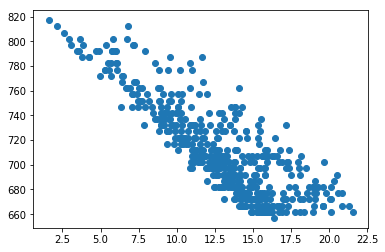

In [92]:
""" Trend between LR model without regularization and FICO score in the data set"""

plt.scatter(x=predictions, y=x_test.fico)

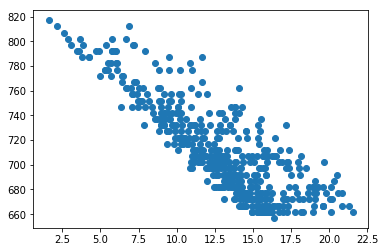

In [93]:
""" Trend between LR model with Ridge regularization and FICO score in the data set"""

plt.scatter(x=predictionsOnTestData, y=x_test.fico)

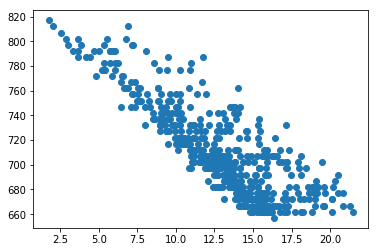

In [94]:
""" Trend between LR model with Lasso regularization and FICO score in the data set"""

plt.scatter(x=predictionsOnTestData_lasso, y=x_test.fico)

### The trend between our response variables and FICO score is linear as we assumed in the beggining. This linearity assumption is what made us choose Linear Regression model. 